# Predicción de Precios Airbnb Buenos Aires - Análisis Completo + Optimización Kaggle

**Objetivo:** Combinar análisis exploratorio exhaustivo con la estrategia optimizada para Kaggle

## Estrategia:
1. 📊 Análisis Exploratorio Completo (EDA)
2. 🔍 Detección de Outliers (sin eliminarlos)
3. 📈 Análisis de Correlaciones
4. 🛠️ Feature Engineering Conservador
5. 🤖 Multiple Modelos + Ensemble
6. 📉 Análisis de Residuos
7. 🎯 Predicciones Optimizadas para Kaggle

---

## 1. Imports y Configuración

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost
import xgboost as xgb

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


## 2. Carga de Datos

In [2]:
# Cargar datasets
df_train = pd.read_csv('../sample_data/train.csv')
df_test = pd.read_csv('../sample_data/test.csv')

print("="*70)
print("CARGA DE DATOS")
print("="*70)
print(f"Dataset de entrenamiento: {df_train.shape}")
print(f"Dataset de test: {df_test.shape}")

# Guardar IDs para submission
test_ids = df_test['id'].copy()
print(f"\n✓ IDs de test guardados: {len(test_ids)}")

print(f"\nPrimeras filas:")
display(df_train.head())

CARGA DE DATOS
Dataset de entrenamiento: (16013, 15)
Dataset de test: (6864, 14)

✓ IDs de test guardados: 6864

Primeras filas:


,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,30814163,"3 bedrooms, 2 bathrooms. Patio, terrace and BBQ!",157770305,Sara,Constitucion,-34.62142,-58.37754,Entire home/apt,2212,1,24,10-11-2019,2.19,4,337
1,32539509,Studio with balcony and gim @Palermo Hollywood,16133446,Luis & Florencia,Palermo,-34.57949,-58.43199,Entire home/apt,2691,2,0,NaN,NaN,52,179
2,36262352,Nice Niceto. Der Wohnung in Buenos aires,257784804,Diego,Palermo,-34.58298,-58.44265,Entire home/apt,1315,2,8,06-10-2019,1.64,1,22
3,1147359,"Soho Artist Studio, breakfast",4215940,Lilian,Palermo,-34.58937,-58.43274,Entire home/apt,2750,1,9,29-01-2019,0.12,6,343
4,26470465,Perfect get-away in Buenos Aires,166597104,Mariangeles,Retiro,-34.59448,-58.37936,Entire home/apt,1076,1,6,10-05-2019,0.42,2,339


In [3]:
# Información detallada del dataset
print("\n" + "="*70)
print("INFORMACIÓN DEL DATASET")
print("="*70)
print(df_train.info())

print("\n" + "="*70)
print("VALORES NULOS POR COLUMNA")
print("="*70)
missing_values = df_train.isnull().sum()
missing_percent = (df_train.isnull().sum() / len(df_train)) * 100

missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores_Nulos': missing_values.values,
    'Porcentaje': missing_percent.values
})
missing_df = missing_df[missing_df['Valores_Nulos'] > 0].sort_values('Porcentaje', ascending=False)

if len(missing_df) > 0:
    display(missing_df)
else:
    print("No hay valores nulos")


INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16013 entries, 0 to 16012
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              16013 non-null  int64  
 1   name                            16005 non-null  object 
 2   host_id                         16013 non-null  int64  
 3   host_name                       16000 non-null  object 
 4   neighbourhood                   16013 non-null  object 
 5   latitude                        16013 non-null  float64
 6   longitude                       16013 non-null  float64
 7   room_type                       16013 non-null  object 
 8   price                           16013 non-null  int64  
 9   minimum_nights                  16013 non-null  int64  
 10  number_of_reviews               16013 non-null  int64  
 11  last_review                     11463 non-null  object 
 12  reviews

,Columna,Valores_Nulos,Porcentaje
12,reviews_per_month,4550,28.414413
11,last_review,4550,28.414413
3,host_name,13,0.081184
1,name,8,0.049959


## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Análisis de la Variable Objetivo (Price)

In [4]:
print("="*70)
print("ESTADÍSTICAS DE PRICE (Variable Objetivo)")
print("="*70)

# Estadísticas descriptivas
print(df_train['price'].describe())
print(f"\nMedia:    ${df_train['price'].mean():,.2f}")
print(f"Mediana:  ${df_train['price'].median():,.2f}")
print(f"Mínimo:   ${df_train['price'].min():,.2f}")
print(f"Máximo:   ${df_train['price'].max():,.2f}")
print(f"Desv.Std: ${df_train['price'].std():,.2f}")
print(f"\nAsimetría (Skewness): {df_train['price'].skew():.4f}")
print(f"Curtosis (Kurtosis):  {df_train['price'].kurtosis():.4f}")

ESTADÍSTICAS DE PRICE (Variable Objetivo)
count     16013.000000
mean       3286.097046
std       13182.202856
min         120.000000
25%        1256.000000
50%        2033.000000
75%        2990.000000
max      597865.000000
Name: price, dtype: float64

Media:    $3,286.10
Mediana:  $2,033.00
Mínimo:   $120.00
Máximo:   $597,865.00
Desv.Std: $13,182.20

Asimetría (Skewness): 32.7136
Curtosis (Kurtosis):  1303.9230


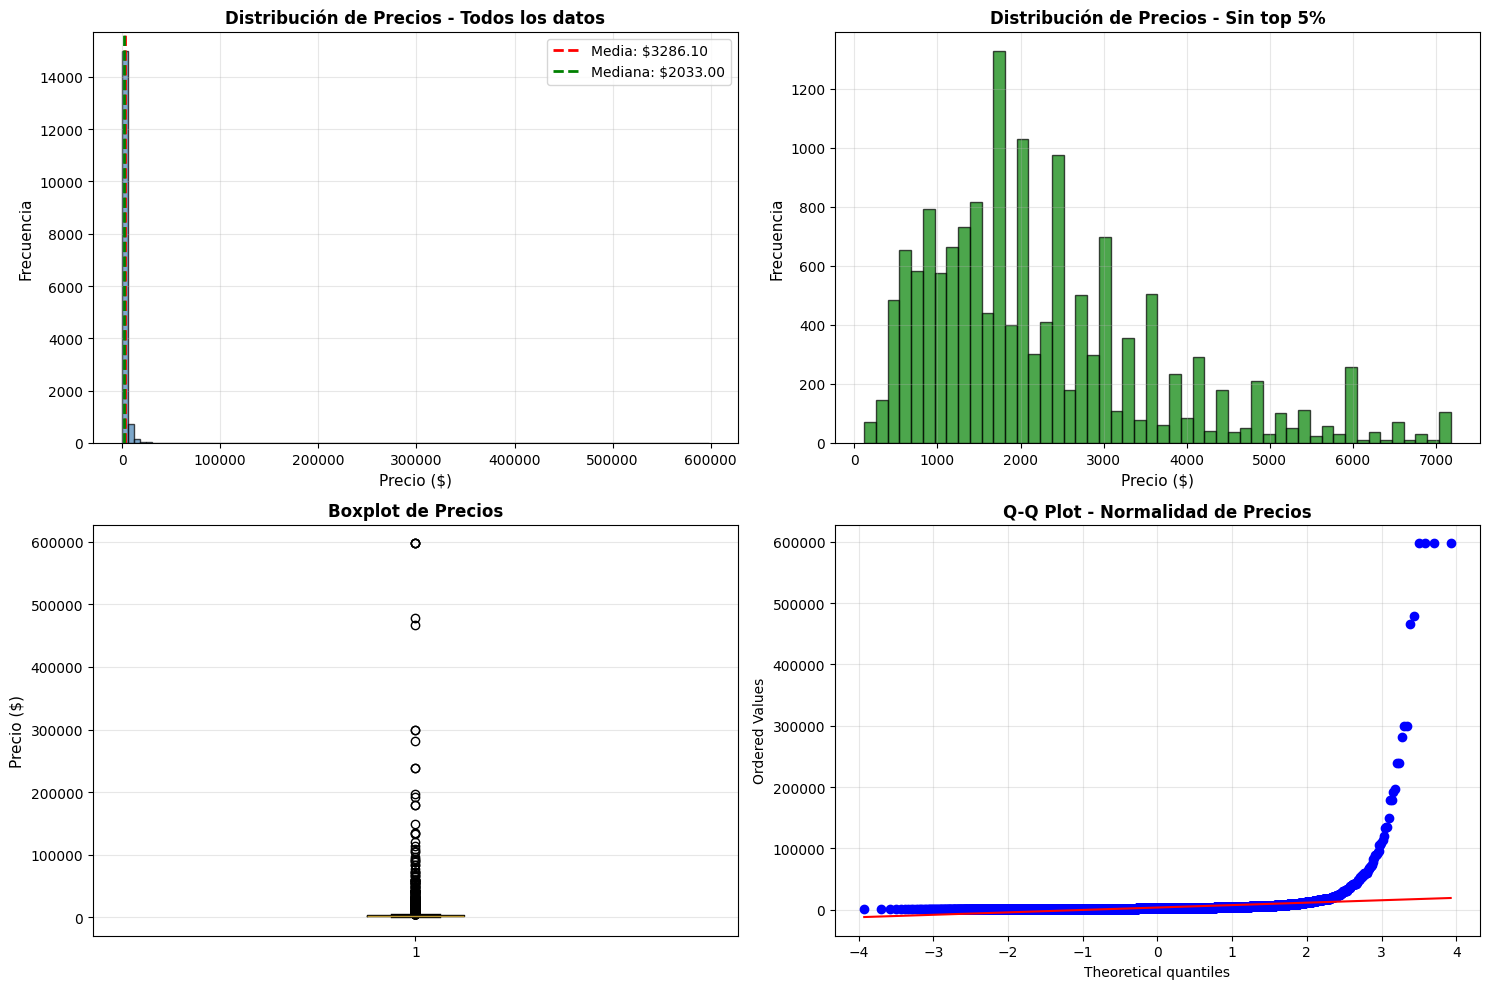


✓ Gráfico guardado: eda_distribucion_price.png


In [5]:
# Visualización de la distribución de precios
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma completo
axes[0, 0].hist(df_train['price'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df_train['price'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Media: ${df_train["price"].mean():.2f}')
axes[0, 0].axvline(df_train['price'].median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Mediana: ${df_train["price"].median():.2f}')
axes[0, 0].set_title('Distribución de Precios - Todos los datos', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Precio ($)', fontsize=11)
axes[0, 0].set_ylabel('Frecuencia', fontsize=11)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Histograma sin extremos (percentil 95)
df_no_extremos = df_train[df_train['price'] <= df_train['price'].quantile(0.95)]
axes[0, 1].hist(df_no_extremos['price'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Distribución de Precios - Sin top 5%', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Precio ($)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].grid(alpha=0.3)

# Boxplot
axes[1, 0].boxplot(df_train['price'], vert=True)
axes[1, 0].set_title('Boxplot de Precios', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Precio ($)', fontsize=11)
axes[1, 0].grid(axis='y', alpha=0.3)

# Q-Q Plot
stats.probplot(df_train['price'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot - Normalidad de Precios', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('eda_distribucion_price.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado: eda_distribucion_price.png")

### 3.2 Análisis de Outliers (IQR Method)

**IMPORTANTE:** Detectamos outliers para entenderlos, pero NO los eliminamos para Kaggle.

In [6]:
# Análisis de outliers con IQR
Q1 = df_train['price'].quantile(0.25)
Q3 = df_train['price'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers_inf = df_train[df_train['price'] < limite_inferior]
outliers_sup = df_train[df_train['price'] > limite_superior]

print("="*70)
print("ANÁLISIS DE OUTLIERS CON MÉTODO IQR")
print("="*70)
print(f"Q1 (25%):              ${Q1:,.2f}")
print(f"Q3 (75%):              ${Q3:,.2f}")
print(f"IQR:                   ${IQR:,.2f}")
print(f"\nLímite inferior:       ${limite_inferior:,.2f}")
print(f"Límite superior:       ${limite_superior:,.2f}")
print(f"\nOutliers inferiores:   {len(outliers_inf)} ({len(outliers_inf)/len(df_train)*100:.2f}%)")
print(f"Outliers superiores:   {len(outliers_sup)} ({len(outliers_sup)/len(df_train)*100:.2f}%)")
print(f"\nTotal de outliers:     {len(outliers_inf) + len(outliers_sup)} ({(len(outliers_inf) + len(outliers_sup))/len(df_train)*100:.2f}%)")

print(f"\n⚠️  DECISIÓN: NO eliminamos outliers (estrategia Kaggle)")
print(f"   Mantuvimos: {len(df_train):,} registros")

ANÁLISIS DE OUTLIERS CON MÉTODO IQR
Q1 (25%):              $1,256.00
Q3 (75%):              $2,990.00
IQR:                   $1,734.00

Límite inferior:       $-1,345.00
Límite superior:       $5,591.00

Outliers inferiores:   0 (0.00%)
Outliers superiores:   1397 (8.72%)

Total de outliers:     1397 (8.72%)

⚠️  DECISIÓN: NO eliminamos outliers (estrategia Kaggle)
   Mantuvimos: 16,013 registros


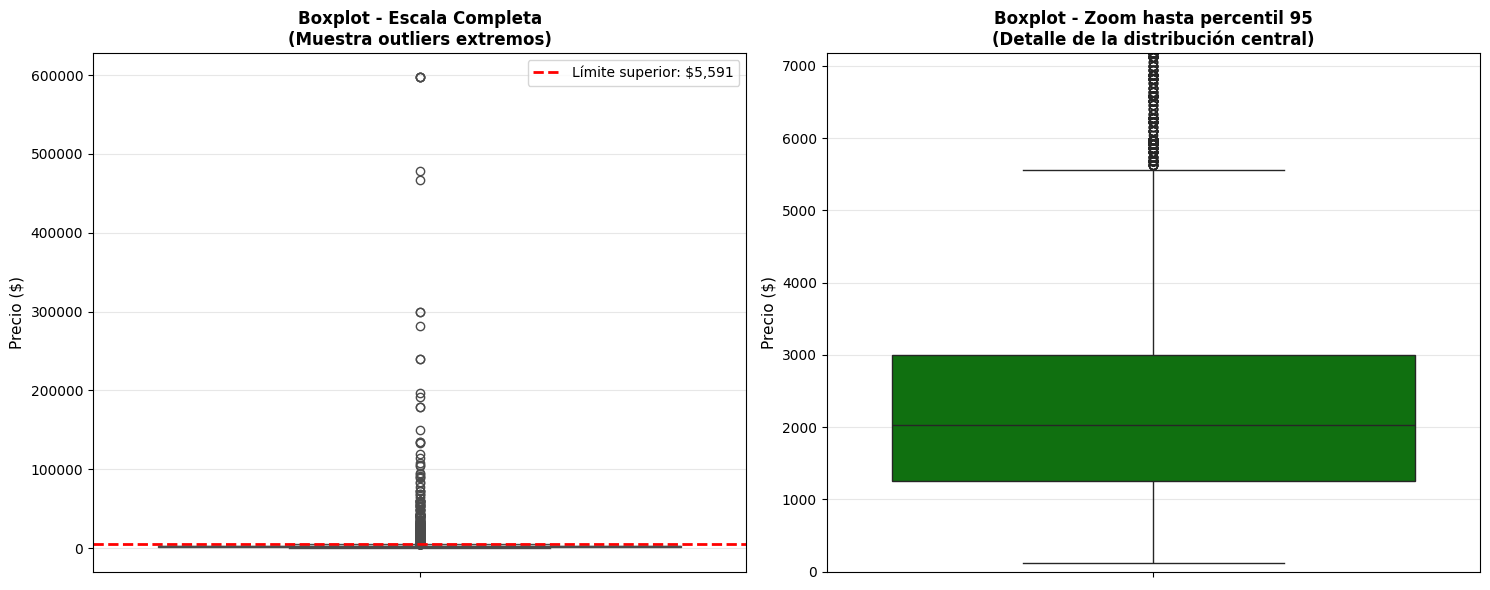

✓ Gráfico guardado: analisis_outliers_boxplot.png


In [7]:
# Visualización detallada de outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Boxplot con escala completa
sns.boxplot(y=df_train['price'], ax=axes[0], color='steelblue')
axes[0].axhline(y=limite_superior, color='red', linestyle='--', linewidth=2, 
                label=f'Límite superior: ${limite_superior:,.0f}')
axes[0].set_title('Boxplot - Escala Completa\n(Muestra outliers extremos)', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precio ($)', fontsize=11)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Zoom en percentil 95
sns.boxplot(y=df_train['price'], ax=axes[1], color='green')
axes[1].set_title('Boxplot - Zoom hasta percentil 95\n(Detalle de la distribución central)', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precio ($)', fontsize=11)
axes[1].set_ylim(0, df_train['price'].quantile(0.95))
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_outliers_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: analisis_outliers_boxplot.png")

### 3.3 Análisis de Variables Categóricas

In [8]:
print("="*70)
print("ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("="*70)

# room_type
print("\n1. ROOM_TYPE:")
print(df_train['room_type'].value_counts())
print(f"\nValores únicos: {df_train['room_type'].nunique()}")

# neighbourhood
print("\n2. NEIGHBOURHOOD:")
print(f"Valores únicos: {df_train['neighbourhood'].nunique()}")
print(f"\nTop 10 barrios:")
print(df_train['neighbourhood'].value_counts().head(10))

ANÁLISIS DE VARIABLES CATEGÓRICAS

1. ROOM_TYPE:
room_type
Entire home/apt    12183
Private room        3206
Shared room          375
Hotel room           249
Name: count, dtype: int64

Valores únicos: 4

2. NEIGHBOURHOOD:
Valores únicos: 48

Top 10 barrios:
neighbourhood
Palermo         4850
Recoleta        2595
San Nicolas      923
Retiro           806
Balvanera        779
Belgrano         740
Almagro          687
Monserrat        641
Villa Crespo     546
San Telmo        489
Name: count, dtype: int64


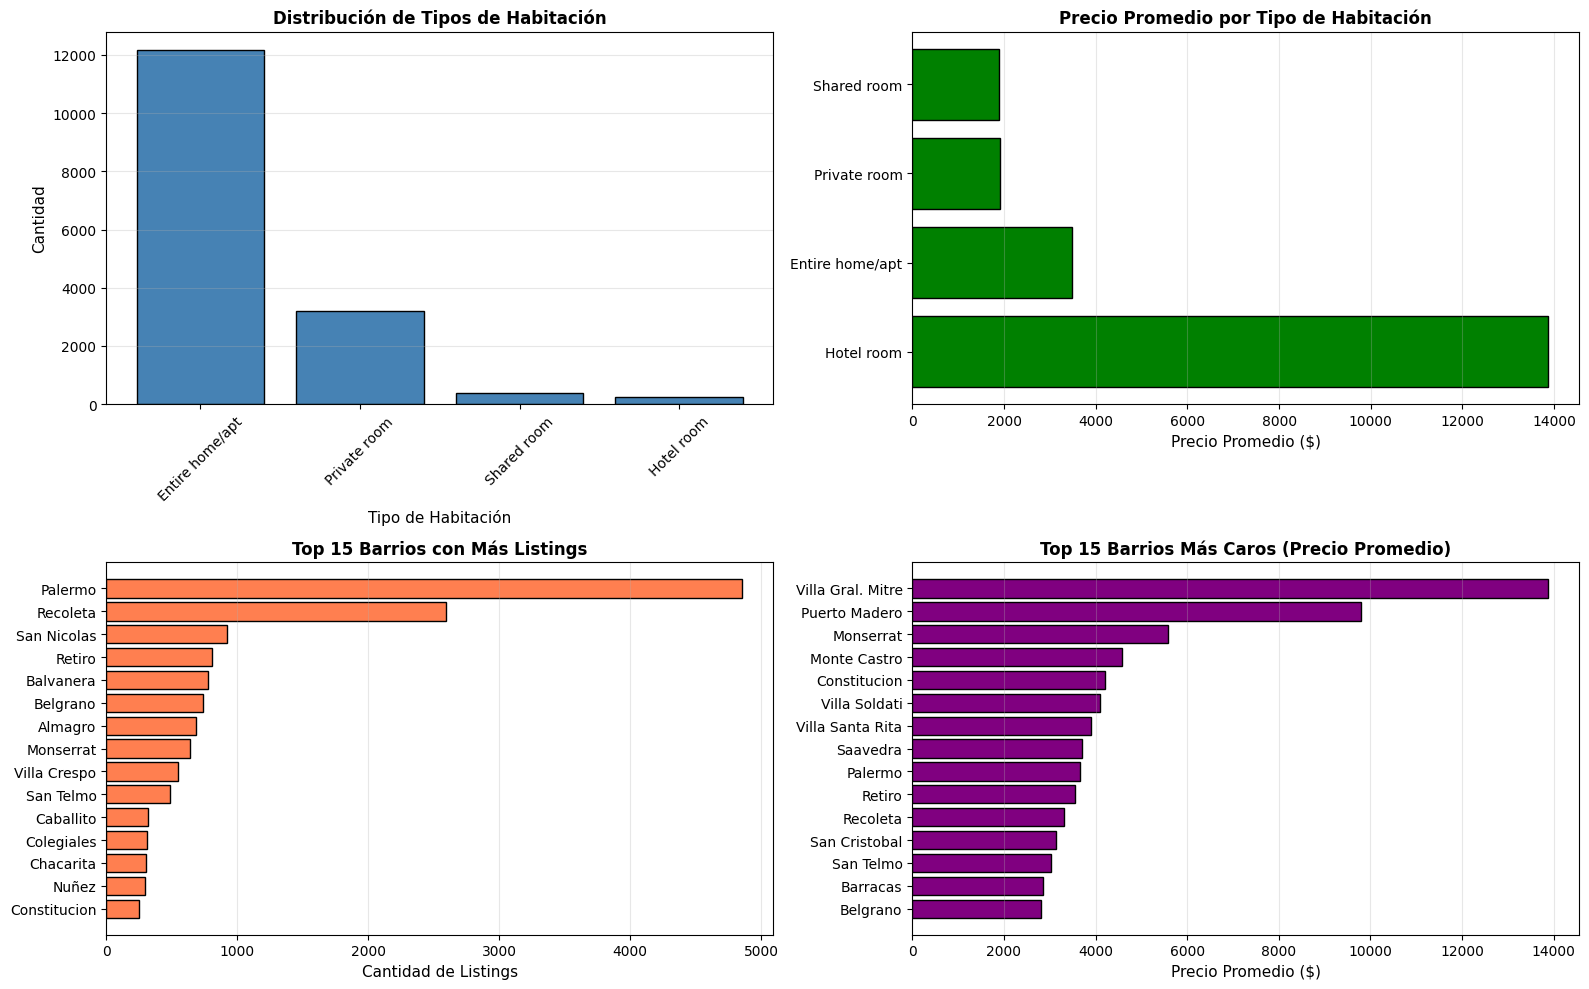

✓ Gráfico guardado: analisis_categoricas.png


In [9]:
# Visualización de variables categóricas
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# room_type - Distribución
room_counts = df_train['room_type'].value_counts()
axes[0, 0].bar(room_counts.index, room_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Distribución de Tipos de Habitación', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Tipo de Habitación', fontsize=11)
axes[0, 0].set_ylabel('Cantidad', fontsize=11)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# room_type - Precio promedio
room_price = df_train.groupby('room_type')['price'].mean().sort_values(ascending=False)
axes[0, 1].barh(room_price.index, room_price.values, color='green', edgecolor='black')
axes[0, 1].set_title('Precio Promedio por Tipo de Habitación', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Precio Promedio ($)', fontsize=11)
axes[0, 1].grid(axis='x', alpha=0.3)

# neighbourhood - Top 15
neigh_counts = df_train['neighbourhood'].value_counts().head(15)
axes[1, 0].barh(neigh_counts.index, neigh_counts.values, color='coral', edgecolor='black')
axes[1, 0].set_title('Top 15 Barrios con Más Listings', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Cantidad de Listings', fontsize=11)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# neighbourhood - Precio promedio Top 15
neigh_price = df_train.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(15)
axes[1, 1].barh(neigh_price.index, neigh_price.values, color='purple', edgecolor='black')
axes[1, 1].set_title('Top 15 Barrios Más Caros (Precio Promedio)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Precio Promedio ($)', fontsize=11)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_categoricas.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: analisis_categoricas.png")

### 3.4 Análisis de Variables Numéricas

In [10]:
# Identificar variables numéricas (excluyendo IDs y price)
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['id', 'host_id', 'price']]

print("="*70)
print("ESTADÍSTICAS DE VARIABLES NUMÉRICAS")
print("="*70)
print(f"\nVariables numéricas ({len(numeric_cols)}):")
for i, col in enumerate(numeric_cols, 1):
    print(f"  {i}. {col}")

print("\n" + "="*70)
display(df_train[numeric_cols].describe())

ESTADÍSTICAS DE VARIABLES NUMÉRICAS

Variables numéricas (7):
  1. latitude
  2. longitude
  3. minimum_nights
  4. number_of_reviews
  5. reviews_per_month
  6. calculated_host_listings_count
  7. availability_365



,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,16013.000000,16013.000000,16013.000000,16013.000000,11463.000000,16013.000000,16013.000000
mean,-34.592509,-58.416304,5.524511,15.275027,1.257176,6.383813,202.430525
std,0.018328,0.029856,19.909682,30.746844,1.393336,14.945548,134.189981
min,-34.688950,-58.530200,1.000000,0.000000,0.010000,1.000000,0.000000
25%,-34.603350,-58.435600,1.000000,0.000000,0.250000,1.000000,83.000000
50%,-34.591870,-58.415850,3.000000,4.000000,0.760000,1.000000,180.000000
75%,-34.581990,-58.392280,4.000000,16.000000,1.800000,4.000000,344.000000
max,-34.534100,-58.354880,1125.000000,451.000000,15.000000,105.000000,365.000000


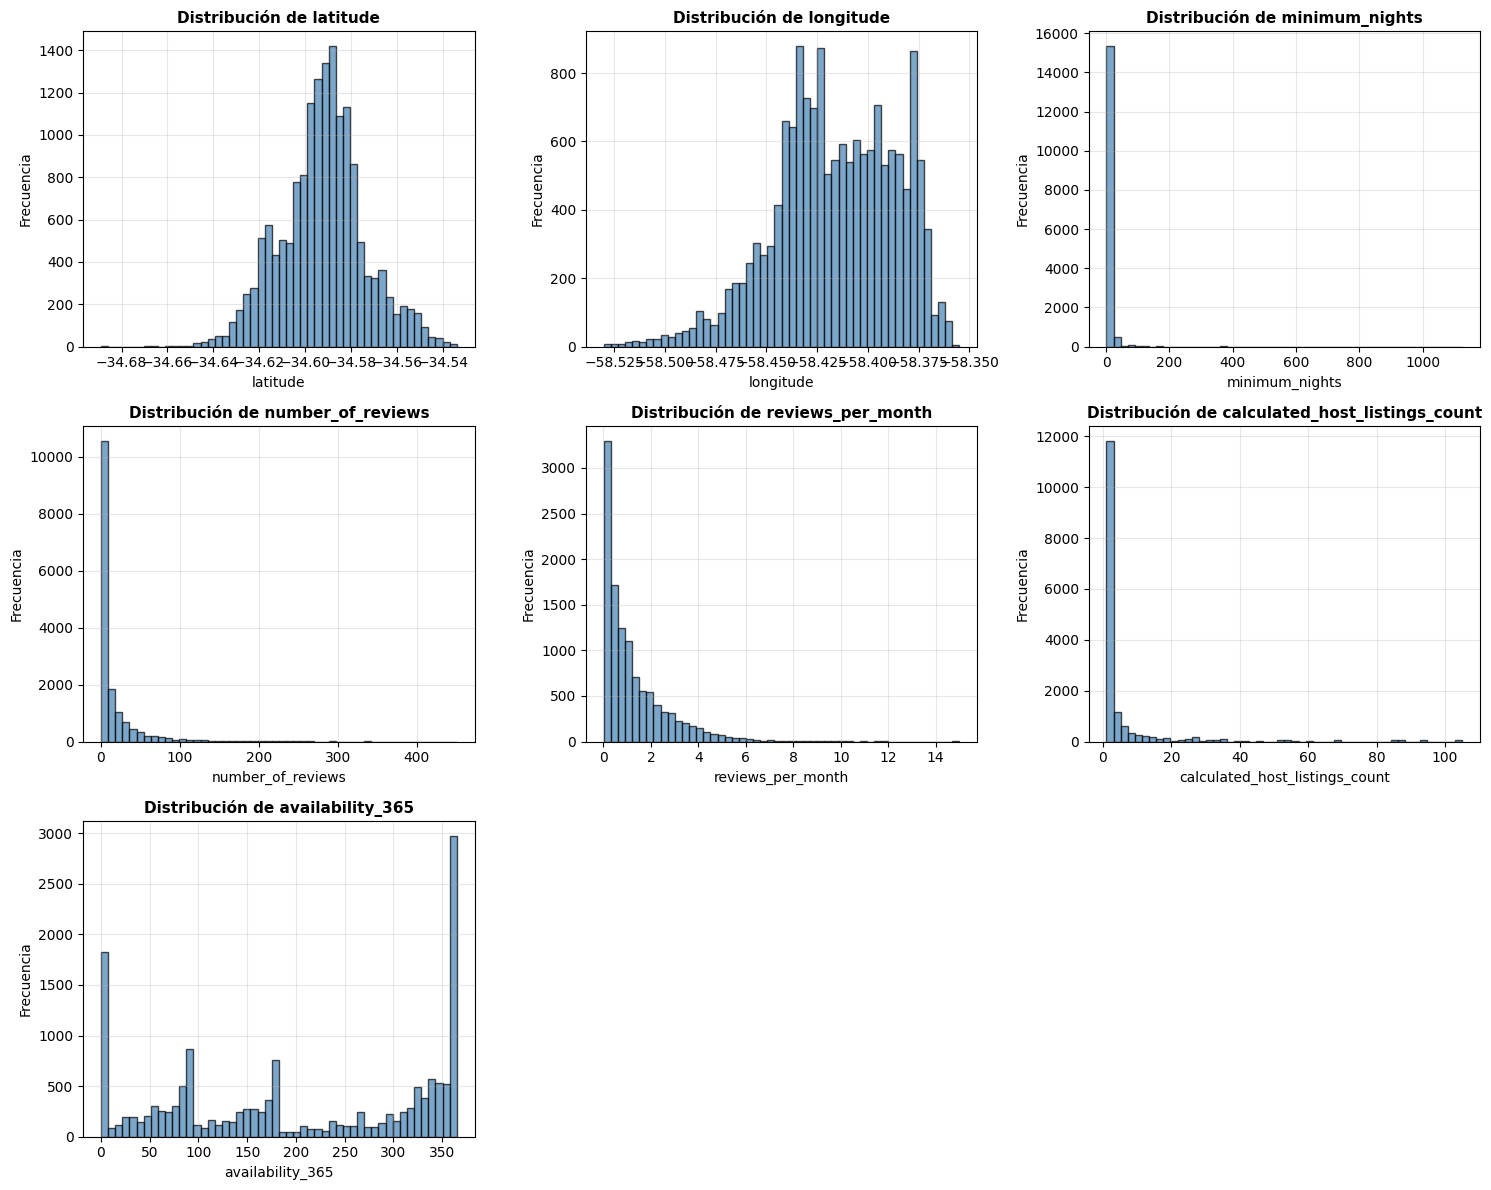

✓ Gráfico guardado: distribucion_numericas.png


In [11]:
# Distribuciones de variables numéricas
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df_train[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f'Distribución de {col}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Frecuencia', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Ocultar ejes sobrantes
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('distribucion_numericas.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: distribucion_numericas.png")

### 3.5 Análisis de Correlaciones

In [12]:
# Matriz de correlación
corr_features = numeric_cols + ['price']
correlation_matrix = df_train[corr_features].corr()

print("="*70)
print("ANÁLISIS DE CORRELACIONES CON PRICE")
print("="*70)

# Correlación con price
price_corr = correlation_matrix['price'].sort_values(ascending=False)
print("\nCorrelación con PRICE (ordenada):")
print(price_corr)

# Identificar correlaciones fuertes
strong_corr = price_corr[(price_corr.abs() > 0.3) & (price_corr.abs() < 1.0)]
print(f"\n\nVariables con correlación fuerte (|r| > 0.3):")
print(strong_corr)

ANÁLISIS DE CORRELACIONES CON PRICE

Correlación con PRICE (ordenada):
price                             1.000000
availability_365                  0.036124
longitude                         0.031439
minimum_nights                    0.030661
calculated_host_listings_count    0.018773
latitude                          0.000674
number_of_reviews                -0.016597
reviews_per_month                -0.018116
Name: price, dtype: float64


Variables con correlación fuerte (|r| > 0.3):
Series([], Name: price, dtype: float64)


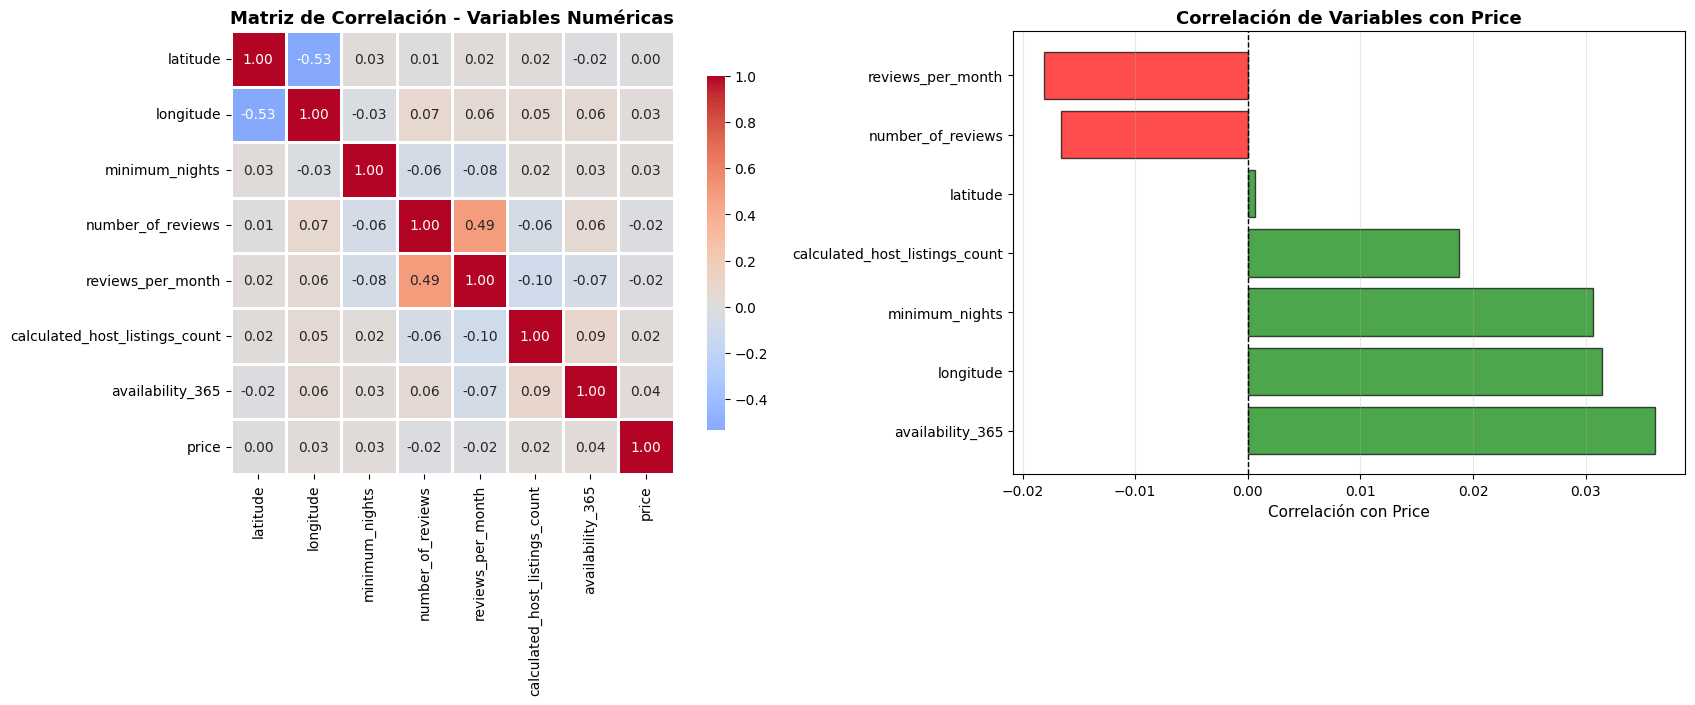


✓ Gráfico guardado: analisis_correlaciones.png


In [13]:
# Visualización de correlaciones
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Heatmap de correlación
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Matriz de Correlación - Variables Numéricas', fontsize=13, fontweight='bold')

# Barplot de correlación con price
price_corr_plot = price_corr[price_corr.index != 'price']
colors = ['green' if x > 0 else 'red' for x in price_corr_plot.values]
axes[1].barh(price_corr_plot.index, price_corr_plot.values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Correlación con Price', fontsize=11)
axes[1].set_title('Correlación de Variables con Price', fontsize=13, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('analisis_correlaciones.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado: analisis_correlaciones.png")

### 3.6 Relaciones Bivariadas con Price

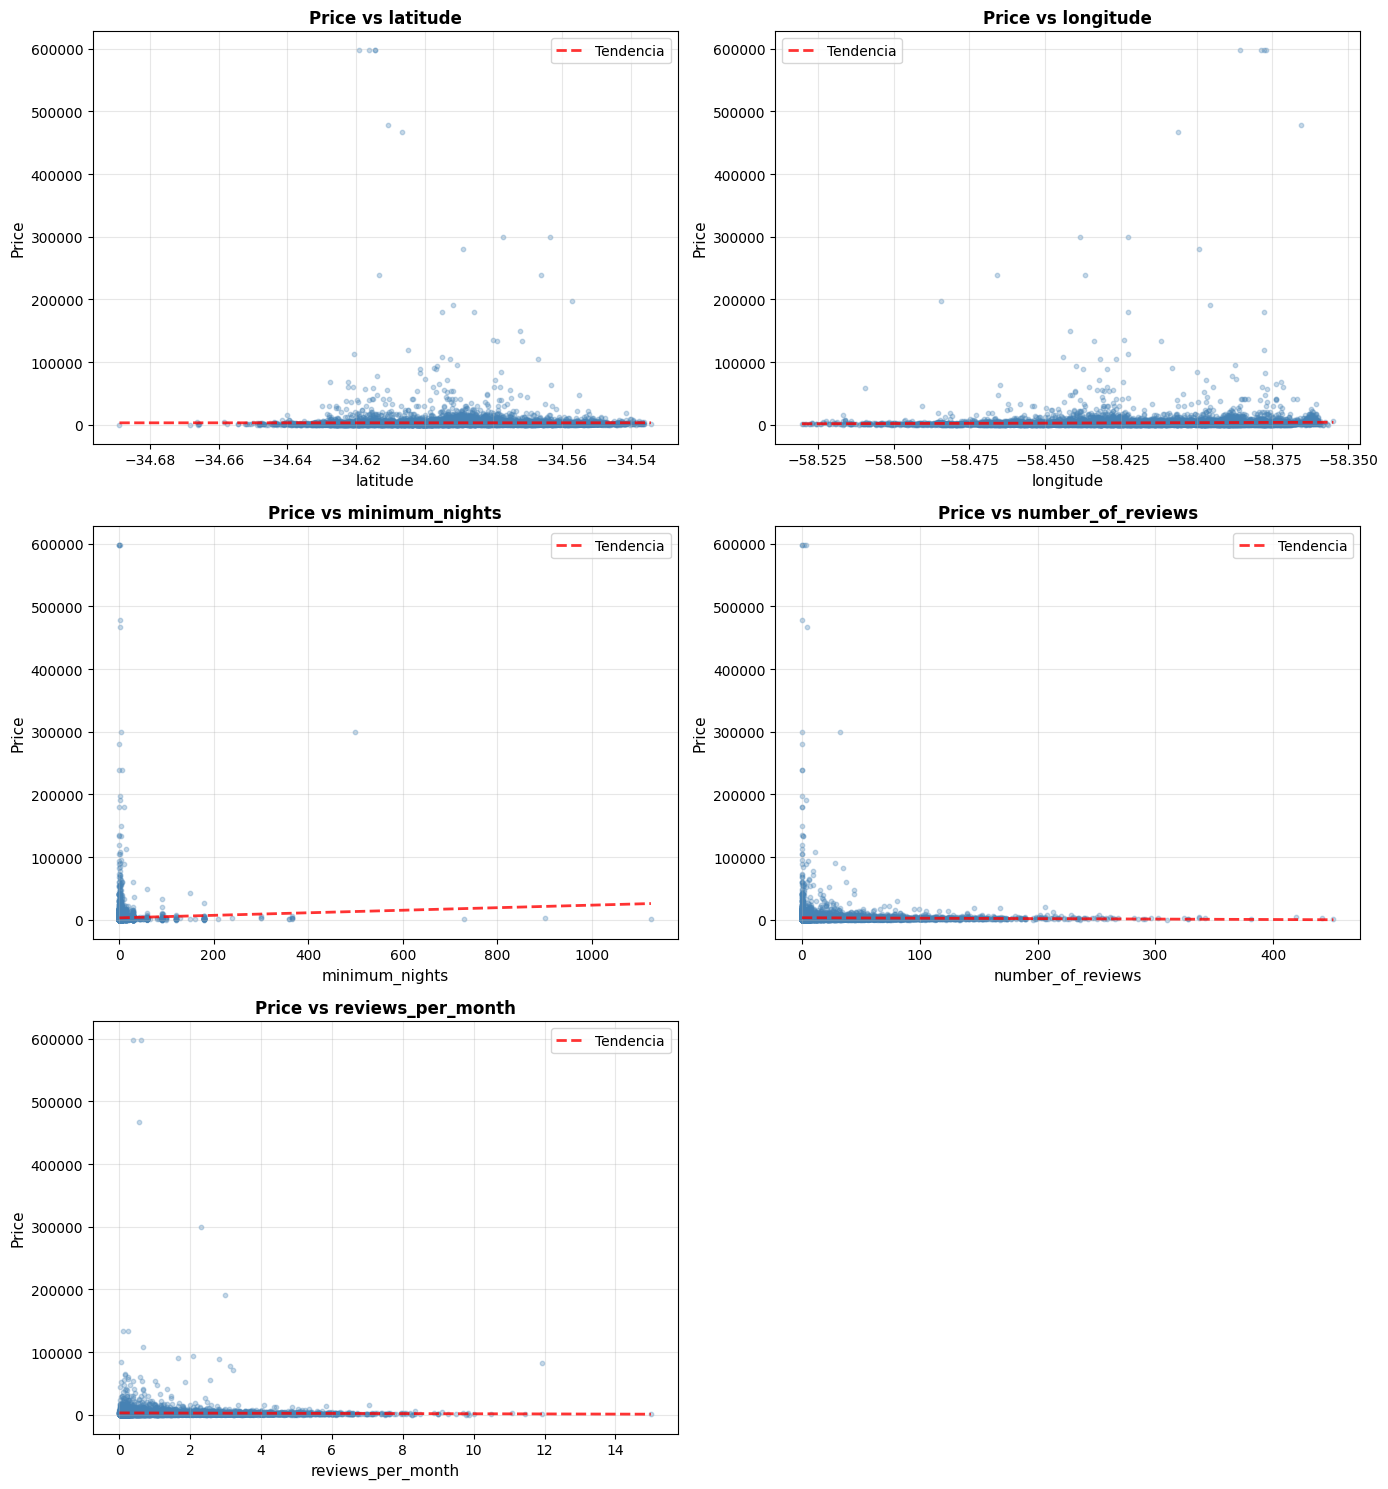

✓ Gráfico guardado: relaciones_bivariadas.png


In [14]:
# Scatterplots de variables numéricas vs price
key_vars = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']
key_vars = [v for v in key_vars if v in numeric_cols]

n_cols = 2
n_rows = int(np.ceil(len(key_vars) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(key_vars):
    axes[idx].scatter(df_train[col], df_train['price'], alpha=0.3, s=10, color='steelblue')
    axes[idx].set_xlabel(col, fontsize=11)
    axes[idx].set_ylabel('Price', fontsize=11)
    axes[idx].set_title(f'Price vs {col}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # Agregar línea de tendencia
    z = np.polyfit(df_train[col].dropna(), df_train.loc[df_train[col].notna(), 'price'], 1)
    p = np.poly1d(z)
    axes[idx].plot(df_train[col].sort_values(), p(df_train[col].sort_values()), 
                   "r--", alpha=0.8, linewidth=2, label='Tendencia')
    axes[idx].legend()

# Ocultar ejes sobrantes
for idx in range(len(key_vars), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('relaciones_bivariadas.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: relaciones_bivariadas.png")

## 4. Preprocesamiento de Datos

### 4.1 Gestión de Valores Nulos

In [15]:
print("="*70)
print("PREPROCESAMIENTO - ESTRATEGIA CONSERVADORA")
print("="*70)

def preprocess_data(df, is_train=True):
    """
    Preprocesa el dataset siguiendo estrategia minimalista.
    """
    df = df.copy()
    
    # 1. Eliminar columnas no predictivas
    columns_to_drop = ['name', 'host_name', 'id', 'host_id']
    df = df.drop([col for col in columns_to_drop if col in df.columns], axis=1)
    print(f"\n{'TRAIN' if is_train else 'TEST'} - Columnas eliminadas: {columns_to_drop}")
    
    # 2. Crear variable indicadora de reseñas
    df['has_reviews'] = (~df['last_review'].isnull()).astype(int)
    print(f"  ✓ Variable 'has_reviews' creada")
    
    # 3. Eliminar last_review (ya tenemos has_reviews)
    df = df.drop('last_review', axis=1)
    print(f"  ✓ Columna 'last_review' eliminada")
    
    # 4. Imputar reviews_per_month con 0 (sin reseñas)
    nulos_antes = df['reviews_per_month'].isnull().sum()
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
    print(f"  ✓ 'reviews_per_month': {nulos_antes} nulos imputados con 0")
    
    # Verificar nulos finales
    nulos_finales = df.isnull().sum().sum()
    print(f"\n  Shape: {df.shape}")
    print(f"  Nulos restantes: {nulos_finales}")
    
    return df

# Aplicar preprocesamiento
df_train_clean = preprocess_data(df_train, is_train=True)
df_test_clean = preprocess_data(df_test, is_train=False)

print("\n" + "="*70)
print("✓ Preprocesamiento completado")
print(f"✓ Mantuvimos TODOS los registros: {len(df_train_clean):,} (NO se eliminaron outliers)")
print("="*70)

PREPROCESAMIENTO - ESTRATEGIA CONSERVADORA

TRAIN - Columnas eliminadas: ['name', 'host_name', 'id', 'host_id']
  ✓ Variable 'has_reviews' creada
  ✓ Columna 'last_review' eliminada
  ✓ 'reviews_per_month': 4550 nulos imputados con 0

  Shape: (16013, 11)
  Nulos restantes: 0

TEST - Columnas eliminadas: ['name', 'host_name', 'id', 'host_id']
  ✓ Variable 'has_reviews' creada
  ✓ Columna 'last_review' eliminada
  ✓ 'reviews_per_month': 1895 nulos imputados con 0

  Shape: (6864, 10)
  Nulos restantes: 0

✓ Preprocesamiento completado
✓ Mantuvimos TODOS los registros: 16,013 (NO se eliminaron outliers)


### 4.2 Feature Engineering (Conservador)

In [16]:
print("="*70)
print("FEATURE ENGINEERING CONSERVADOR")
print("="*70)

# Centro de Buenos Aires
BBAA_CENTER = [-34.59977951146896, -58.38320368379193]

def create_features(df):
    """
    Crea features adicionales de forma conservadora.
    Solo features que han demostrado ser útiles.
    """
    df = df.copy()
    
    # Feature 1: Distancia al centro
    df['distance_to_center'] = np.sqrt(
        (df['latitude'] - BBAA_CENTER[0])**2 + 
        (df['longitude'] - BBAA_CENTER[1])**2
    )
    print("  ✓ distance_to_center creada")
    
    # Feature 2: Host profesional (múltiples listings)
    df['is_professional_host'] = (df['calculated_host_listings_count'] > 1).astype(int)
    print("  ✓ is_professional_host creada")
    
    return df

print("\nCreando features...")
df_train_clean = create_features(df_train_clean)
df_test_clean = create_features(df_test_clean)

print(f"\n✓ Feature engineering completado")
print(f"  Shape train: {df_train_clean.shape}")
print(f"  Shape test:  {df_test_clean.shape}")

FEATURE ENGINEERING CONSERVADOR

Creando features...
  ✓ distance_to_center creada
  ✓ is_professional_host creada
  ✓ distance_to_center creada
  ✓ is_professional_host creada

✓ Feature engineering completado
  Shape train: (16013, 13)
  Shape test:  (6864, 12)


### 4.3 Encoding con OneHotEncoder (Robusto)

In [17]:
print("="*70)
print("ENCODING DE VARIABLES CATEGÓRICAS CON OneHotEncoder")
print("="*70)

# Variables categóricas
categorical_features = ['room_type', 'neighbourhood']

print(f"\nVariables categóricas a encodear:")
for col in categorical_features:
    n_unique_train = df_train_clean[col].nunique()
    n_unique_test = df_test_clean[col].nunique()
    print(f"  - {col}: {n_unique_train} categorías en train, {n_unique_test} en test")

print("\n" + "="*70)
print("Ventajas de OneHotEncoder vs pd.get_dummies():")
print("  1. Garantiza mismas columnas en train y test")
print("  2. Maneja categorías desconocidas con handle_unknown='ignore'")
print("  3. Permite reutilizar el encoder (fit una vez, transform muchas veces)")
print("  4. Approach recomendado para producción")
print("="*70)

# Crear encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# FIT en train
print(f"\nFIT del encoder en TRAIN...")
encoder.fit(df_train_clean[categorical_features])

# TRANSFORM en ambos
print(f"TRANSFORM en TRAIN...")
encoded_train = encoder.transform(df_train_clean[categorical_features])

print(f"TRANSFORM en TEST...")
encoded_test = encoder.transform(df_test_clean[categorical_features])

# Obtener nombres de columnas
feature_names = encoder.get_feature_names_out(categorical_features)

# Crear DataFrames
df_encoded_train = pd.DataFrame(encoded_train, columns=feature_names, index=df_train_clean.index)
df_encoded_test = pd.DataFrame(encoded_test, columns=feature_names, index=df_test_clean.index)

# Combinar
df_train_final = df_train_clean.drop(columns=categorical_features)
df_train_final = pd.concat([df_train_final, df_encoded_train], axis=1)

df_test_final = df_test_clean.drop(columns=categorical_features)
df_test_final = pd.concat([df_test_final, df_encoded_test], axis=1)

print(f"\n✓ Encoding completado:")
print(f"  - Columnas generadas: {len(feature_names)}")
print(f"  - Shape train final: {df_train_final.shape}")
print(f"  - Shape test final:  {df_test_final.shape}")

print(f"\nPrimeras 10 columnas generadas:")
for i, col in enumerate(list(feature_names)[:10], 1):
    print(f"  {i}. {col}")
print(f"  ... y {len(feature_names) - 10} columnas más")

ENCODING DE VARIABLES CATEGÓRICAS CON OneHotEncoder

Variables categóricas a encodear:
  - room_type: 4 categorías en train, 4 en test
  - neighbourhood: 48 categorías en train, 48 en test

Ventajas de OneHotEncoder vs pd.get_dummies():
  1. Garantiza mismas columnas en train y test
  2. Maneja categorías desconocidas con handle_unknown='ignore'
  3. Permite reutilizar el encoder (fit una vez, transform muchas veces)
  4. Approach recomendado para producción

FIT del encoder en TRAIN...
TRANSFORM en TRAIN...
TRANSFORM en TEST...

✓ Encoding completado:
  - Columnas generadas: 50
  - Shape train final: (16013, 61)
  - Shape test final:  (6864, 60)

Primeras 10 columnas generadas:
  1. room_type_Hotel room
  2. room_type_Private room
  3. room_type_Shared room
  4. neighbourhood_Almagro
  5. neighbourhood_Balvanera
  6. neighbourhood_Barracas
  7. neighbourhood_Belgrano
  8. neighbourhood_Boca
  9. neighbourhood_Boedo
  10. neighbourhood_Caballito
  ... y 40 columnas más


### 4.4 Preparación Final

In [18]:
print("="*70)
print("PREPARACIÓN FINAL DE DATOS")
print("="*70)

# Separar features y target
X = df_train_final.drop('price', axis=1)
y = df_train_final['price']

print(f"\nDimensiones:")
print(f"  - Features (X): {X.shape}")
print(f"  - Target (y):   {y.shape}")

# Split para validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\nDivisión de datos (70/30):")
print(f"  - Train: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Test:  {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\n✓ Datos preparados para entrenamiento")
print(f"\nColumnas finales ({len(X.columns)}):")
for i, col in enumerate(list(X.columns)[:15], 1):
    print(f"  {i:2d}. {col}")
if len(X.columns) > 15:
    print(f"  ... y {len(X.columns) - 15} columnas más")

PREPARACIÓN FINAL DE DATOS

Dimensiones:
  - Features (X): (16013, 60)
  - Target (y):   (16013,)

División de datos (70/30):
  - Train: 11,209 muestras (70.0%)
  - Test:  4,804 muestras (30.0%)

✓ Datos preparados para entrenamiento

Columnas finales (60):
   1. latitude
   2. longitude
   3. minimum_nights
   4. number_of_reviews
   5. reviews_per_month
   6. calculated_host_listings_count
   7. availability_365
   8. has_reviews
   9. distance_to_center
  10. is_professional_host
  11. room_type_Hotel room
  12. room_type_Private room
  13. room_type_Shared room
  14. neighbourhood_Almagro
  15. neighbourhood_Balvanera
  ... y 45 columnas más


## 5. Entrenamiento de Modelos

Entrenamos múltiples modelos para comparar y luego crear un ensemble.

### 5.1 Función de Evaluación

In [19]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Evalúa un modelo y muestra métricas detalladas.
    """
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas Train
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Métricas Test
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"\n{'='*70}")
    print(f"{model_name}")
    print(f"{'='*70}")
    
    print(f"\nMÉTRICAS - Train:")
    print(f"  RMSE: ${train_rmse:,.2f}")
    print(f"  MAE:  ${train_mae:,.2f}")
    print(f"  R²:   {train_r2:.6f}")
    
    print(f"\nMÉTRICAS - Test:")
    print(f"  RMSE: ${test_rmse:,.2f}")
    print(f"  MAE:  ${test_mae:,.2f}")
    print(f"  R²:   {test_r2:.6f}")
    
    # Detectar overfitting
    overfit_diff = train_r2 - test_r2
    if overfit_diff > 0.1:
        print(f"\n  ⚠️  Posible overfitting (R² train - test = {overfit_diff:.4f})")
    
    return {
        'model_name': model_name,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'predictions': y_test_pred
    }

print("✓ Función de evaluación definida")

✓ Función de evaluación definida


### 5.2 Cross-Validation y Optimización de Hiperparámetros

**Estrategia para evitar overfitting:**
- Usamos 5-Fold Cross-Validation para validar modelos
- GridSearchCV para encontrar mejores hiperparámetros
- Regularización fuerte (alpha más alto en Ridge/Lasso)
- Menor complejidad en modelos de árbol

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import learning_curve

print("="*70)
print("CONFIGURACIÓN DE CROSS-VALIDATION")
print("="*70)

# Parámetros de CV
CV_FOLDS = 5
SCORING = 'neg_root_mean_squared_error'

print(f"
Folds: {CV_FOLDS}")
print(f"Métrica: {SCORING}")
print(f"
✓ Cross-Validation configurado")

In [ ]:
def evaluate_model_with_cv(model, X_train, y_train, X_test, y_test, model_name):
    """
    Evalúa modelo con Cross-Validation para detectar overfitting.
    """
    # Cross-Validation
    cv_scores = cross_val_score(model, X_train, y_train, 
                                cv=CV_FOLDS, scoring=SCORING, n_jobs=-1)
    cv_rmse_mean = -cv_scores.mean()
    cv_rmse_std = cv_scores.std()
    
    # Entrenar en todo el training set
    model.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas Train
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Métricas Test
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"
{'='*70}")
    print(f"{model_name}")
    print(f"{'='*70}")
    
    print(f"
CROSS-VALIDATION ({CV_FOLDS}-Fold):")
    print(f"  RMSE: ${cv_rmse_mean:,.2f} (+/- ${cv_rmse_std:,.2f})")
    
    print(f"
MÉTRICAS - Train:")
    print(f"  RMSE: ${train_rmse:,.2f}")
    print(f"  MAE:  ${train_mae:,.2f}")
    print(f"  R²:   {train_r2:.6f}")
    
    print(f"
MÉTRICAS - Test:")
    print(f"  RMSE: ${test_rmse:,.2f}")
    print(f"  MAE:  ${test_mae:,.2f}")
    print(f"  R²:   {test_r2:.6f}")
    
    # Detectar overfitting
    overfit_diff = train_r2 - test_r2
    if overfit_diff > 0.15:
        print(f"
  ⚠️  OVERFITTING SEVERO (R² diff = {overfit_diff:.4f})")
    elif overfit_diff > 0.1:
        print(f"
  ⚠️  Posible overfitting (R² diff = {overfit_diff:.4f})")
    elif overfit_diff > 0.05:
        print(f"
  ⚙️  Leve overfitting (R² diff = {overfit_diff:.4f})")
    else:
        print(f"
  ✓ Buen balance (R² diff = {overfit_diff:.4f})")
    
    return {
        'model_name': model_name,
        'cv_rmse_mean': cv_rmse_mean,
        'cv_rmse_std': cv_rmse_std,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'predictions': y_test_pred
    }

print("✓ Función de evaluación con CV definida")

### 5.2 Modelo 1: Linear Regression (Baseline)

In [20]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

results_lr = evaluate_model(lr_model, X_train, y_train, X_test, y_test, 
                            'MODELO 1: LINEAR REGRESSION (Baseline)')


MODELO 1: LINEAR REGRESSION (Baseline)

MÉTRICAS - Train:
  RMSE: $13,776.18
  MAE:  $2,445.59
  R²:   0.021703

MÉTRICAS - Test:
  RMSE: $11,156.90
  MAE:  $2,322.29
  R²:   0.016226


### 5.3 Modelo 2: Ridge Regression

In [21]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

results_ridge = evaluate_model(ridge_model, X_train, y_train, X_test, y_test,
                               'MODELO 2: RIDGE REGRESSION (L2)')


MODELO 2: RIDGE REGRESSION (L2)

MÉTRICAS - Train:
  RMSE: $13,779.25
  MAE:  $2,431.91
  R²:   0.021266

MÉTRICAS - Test:
  RMSE: $11,145.98
  MAE:  $2,300.36
  R²:   0.018151


### 5.4 Modelo 3: Lasso Regression (L1)

In [ ]:
# Lasso Regression (con selección de features)
lasso_model = Lasso(alpha=1.0, max_iter=10000)
lasso_model.fit(X_train, y_train)

# Contar features seleccionados (coef != 0)
features_selected = np.sum(lasso_model.coef_ != 0)
print(f"
Features seleccionados por Lasso: {features_selected}/{len(X.columns)}")

results_lasso = evaluate_model(lasso_model, X_train, y_train, X_test, y_test,
                               'MODELO 3: LASSO REGRESSION (L1)')

### 5.5 Modelo 4: Decision Tree

In [22]:
# Decision Tree
dt_model = DecisionTreeRegressor(max_depth=10, min_samples_split=20, 
                                  min_samples_leaf=10, random_state=42)
dt_model.fit(X_train, y_train)

results_dt = evaluate_model(dt_model, X_train, y_train, X_test, y_test,
                            'MODELO 4: DECISION TREE')


MODELO 3: DECISION TREE

MÉTRICAS - Train:
  RMSE: $12,792.77
  MAE:  $2,328.11
  R²:   0.156389

MÉTRICAS - Test:
  RMSE: $12,675.62
  MAE:  $2,491.54
  R²:   -0.269833

  ⚠️  Posible overfitting (R² train - test = 0.4262)


### 5.6 Modelo 5: Random Forest

In [23]:
# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

results_rf = evaluate_model(rf_model, X_train, y_train, X_test, y_test,
                            'MODELO 5: RANDOM FOREST')


MODELO 4: RANDOM FOREST

MÉTRICAS - Train:
  RMSE: $11,537.71
  MAE:  $1,950.05
  R²:   0.313798

MÉTRICAS - Test:
  RMSE: $10,804.73
  MAE:  $2,206.17
  R²:   0.077352

  ⚠️  Posible overfitting (R² train - test = 0.2364)


### 5.7 Modelo 6: Gradient Boosting

In [24]:
# Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train, y_train)

results_gb = evaluate_model(gb_model, X_train, y_train, X_test, y_test,
                            'MODELO 6: GRADIENT BOOSTING')


MODELO 5: GRADIENT BOOSTING

MÉTRICAS - Train:
  RMSE: $7,720.47
  MAE:  $2,038.13
  R²:   0.692744

MÉTRICAS - Test:
  RMSE: $11,678.44
  MAE:  $2,563.64
  R²:   -0.077899

  ⚠️  Posible overfitting (R² train - test = 0.7706)


### 5.8 Modelo 7: XGBoost (Mejor para datos tabulares)

In [25]:
# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

results_xgb = evaluate_model(xgb_model, X_train, y_train, X_test, y_test,
                             'MODELO 7: XGBoost ⭐')


MODELO 6: XGBoost ⭐

MÉTRICAS - Train:
  RMSE: $5,073.85
  MAE:  $1,723.31
  R²:   0.867294

MÉTRICAS - Test:
  RMSE: $11,211.32
  MAE:  $2,691.91
  R²:   0.006606

  ⚠️  Posible overfitting (R² train - test = 0.8607)


### 5.9 Modelo 8: Neural Network (MLPRegressor)

In [26]:
# Escalar datos para NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural Network
nn_model = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
nn_model.fit(X_train_scaled, y_train)

# Evaluar con datos escalados
y_train_pred_nn = nn_model.predict(X_train_scaled)
y_test_pred_nn = nn_model.predict(X_test_scaled)

results_nn = {
    'model_name': 'MODELO 8: NEURAL NETWORK',
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_nn)),
    'train_mae': mean_absolute_error(y_train, y_train_pred_nn),
    'train_r2': r2_score(y_train, y_train_pred_nn),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_nn)),
    'test_mae': mean_absolute_error(y_test, y_test_pred_nn),
    'test_r2': r2_score(y_test, y_test_pred_nn),
    'predictions': y_test_pred_nn
}

print(f"\n{'='*70}")
print(f"MODELO 8: NEURAL NETWORK")
print(f"{'='*70}")
print(f"\nMÉTRICAS - Train:")
print(f"  RMSE: ${results_nn['train_rmse']:,.2f}")
print(f"  MAE:  ${results_nn['train_mae']:,.2f}")
print(f"  R²:   {results_nn['train_r2']:.6f}")
print(f"\nMÉTRICAS - Test:")
print(f"  RMSE: ${results_nn['test_rmse']:,.2f}")
print(f"  MAE:  ${results_nn['test_mae']:,.2f}")
print(f"  R²:   {results_nn['test_r2']:.6f}")
print(f"\n  Iteraciones: {nn_model.n_iter_}")


MODELO 7: NEURAL NETWORK

MÉTRICAS - Train:
  RMSE: $13,854.77
  MAE:  $2,272.49
  R²:   0.010509

MÉTRICAS - Test:
  RMSE: $11,186.21
  MAE:  $2,104.24
  R²:   0.011051

  Iteraciones: 17


## 6. Comparación Detallada de Modelos

In [27]:
# Crear DataFrame de comparación
all_results = [results_lr, results_ridge, results_lasso, results_dt, results_rf, results_gb, results_xgb, results_nn]

comparison_df = pd.DataFrame([
    {
        'Modelo': r['model_name'].replace('MODELO ', '').replace(': ', ': '),
        'RMSE_Train': r['train_rmse'],
        'RMSE_Test': r['test_rmse'],
        'MAE_Test': r['test_mae'],
        'R2_Train': r['train_r2'],
        'R2_Test': r['test_r2'],
        'Overfit': r['train_r2'] - r['test_r2']
    }
    for r in all_results
]).sort_values('RMSE_Test')

print("\n" + "="*90)
print("COMPARACIÓN COMPLETA DE MODELOS (Ordenado por RMSE Test)")
print("="*90)
display(comparison_df)

# Guardar comparación
comparison_df.to_csv('model_comparison_completo.csv', index=False)
print("\n✓ Tabla guardada: model_comparison_completo.csv")


COMPARACIÓN COMPLETA DE MODELOS (Ordenado por RMSE Test)


,Modelo,RMSE_Train,RMSE_Test,MAE_Test,R2_Train,R2_Test,Overfit
3,4: RANDOM FOREST,11537.705500,10804.728806,2206.173431,0.313798,0.077352,0.236446
1,2: RIDGE REGRESSION (L2),13779.252690,11145.977863,2300.364029,0.021266,0.018151,0.003116
0,1: LINEAR REGRESSION (Baseline),13776.179517,11156.898429,2322.287652,0.021703,0.016226,0.005477
6,7: NEURAL NETWORK,13854.773111,11186.206792,2104.242811,0.010509,0.011051,-0.000542
5,6: XGBoost ⭐,5073.853565,11211.315712,2691.910400,0.867294,0.006606,0.860689
4,5: GRADIENT BOOSTING,7720.466131,11678.437909,2563.641185,0.692744,-0.077899,0.770643
2,3: DECISION TREE,12792.765742,12675.615695,2491.540265,0.156389,-0.269833,0.426222



✓ Tabla guardada: model_comparison_completo.csv


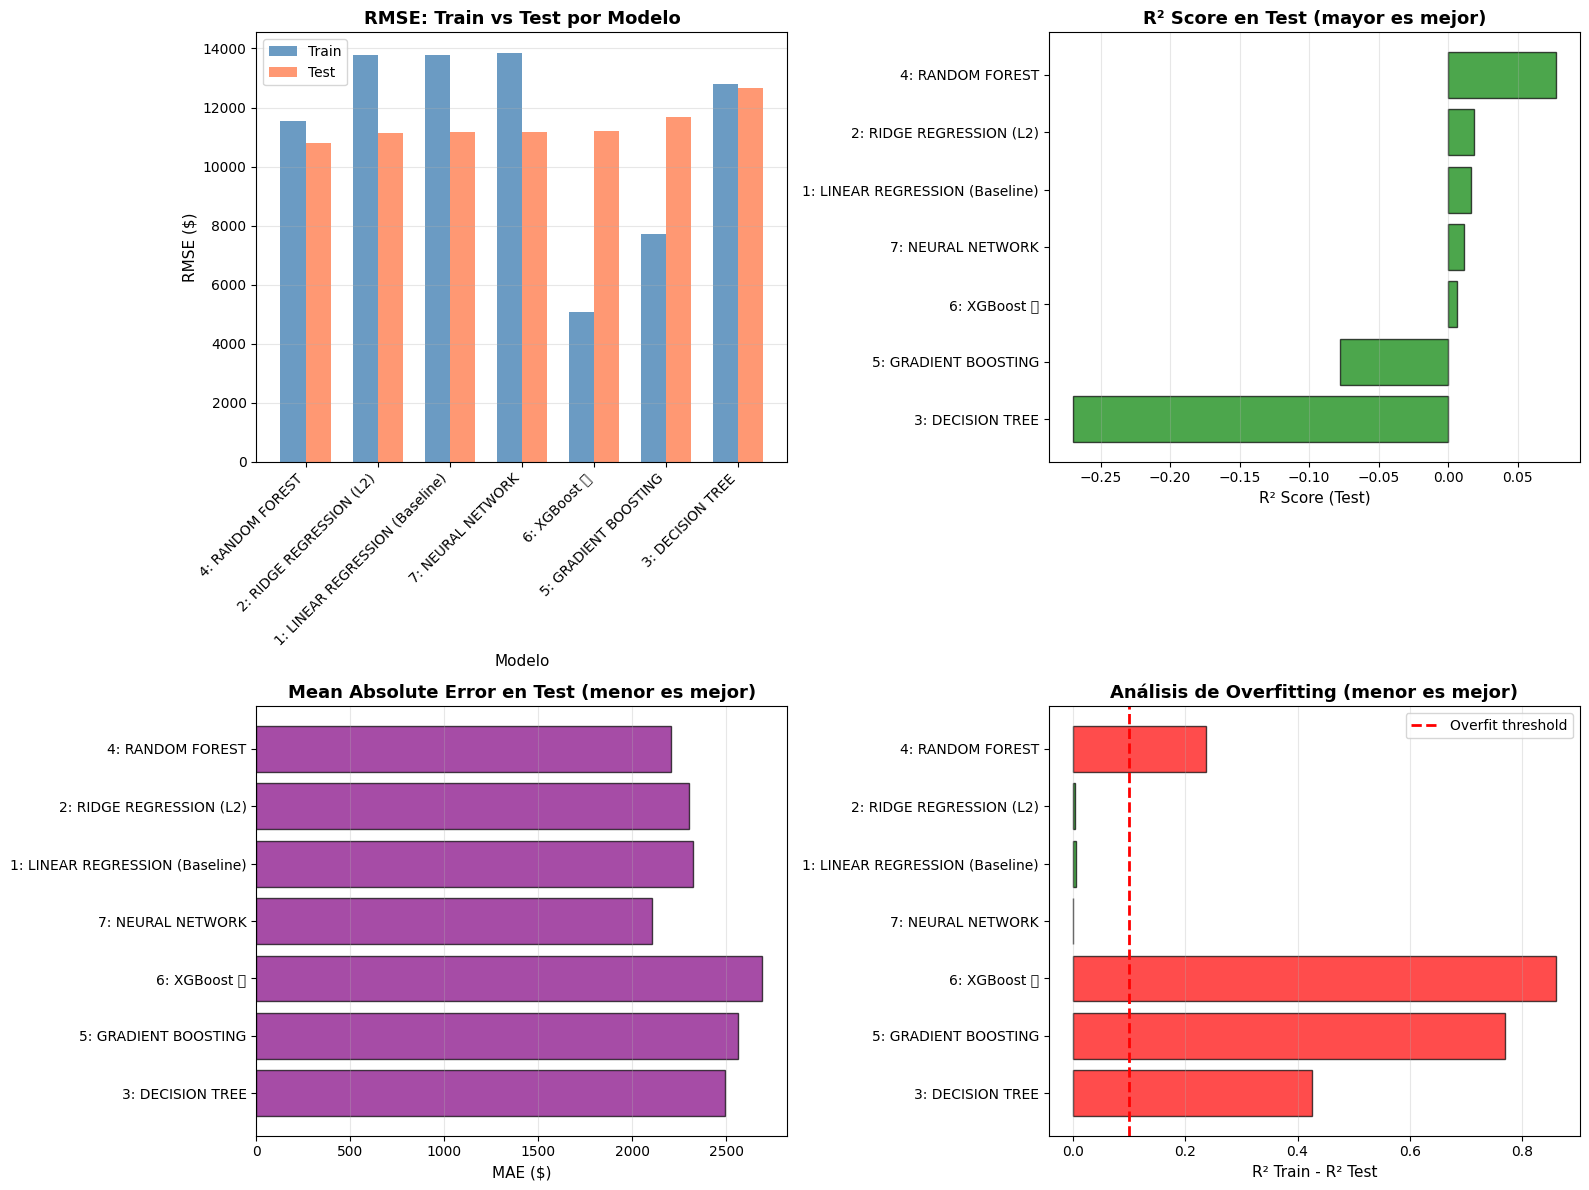


✓ Gráfico guardado: comparacion_completa_modelos.png


In [28]:
# Visualización comparativa completa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE Comparison
x = np.arange(len(comparison_df))
width = 0.35
axes[0, 0].bar(x - width/2, comparison_df['RMSE_Train'], width, label='Train', color='steelblue', alpha=0.8)
axes[0, 0].bar(x + width/2, comparison_df['RMSE_Test'], width, label='Test', color='coral', alpha=0.8)
axes[0, 0].set_xlabel('Modelo', fontsize=11)
axes[0, 0].set_ylabel('RMSE ($)', fontsize=11)
axes[0, 0].set_title('RMSE: Train vs Test por Modelo', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(comparison_df['Modelo'], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. R² Score
axes[0, 1].barh(comparison_df['Modelo'], comparison_df['R2_Test'], color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('R² Score (Test)', fontsize=11)
axes[0, 1].set_title('R² Score en Test (mayor es mejor)', fontsize=13, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. MAE
axes[1, 0].barh(comparison_df['Modelo'], comparison_df['MAE_Test'], color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('MAE ($)', fontsize=11)
axes[1, 0].set_title('Mean Absolute Error en Test (menor es mejor)', fontsize=13, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Overfitting Analysis
colors_overfit = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'green' for x in comparison_df['Overfit']]
axes[1, 1].barh(comparison_df['Modelo'], comparison_df['Overfit'], color=colors_overfit, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0.1, color='red', linestyle='--', linewidth=2, label='Overfit threshold')
axes[1, 1].set_xlabel('R² Train - R² Test', fontsize=11)
axes[1, 1].set_title('Análisis de Overfitting (menor es mejor)', fontsize=13, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].legend()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('comparacion_completa_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado: comparacion_completa_modelos.png")

## 7. Análisis de Residuos (Mejor Modelo)


Mejor modelo: 4: RANDOM FOREST
RMSE Test: $10,804.73


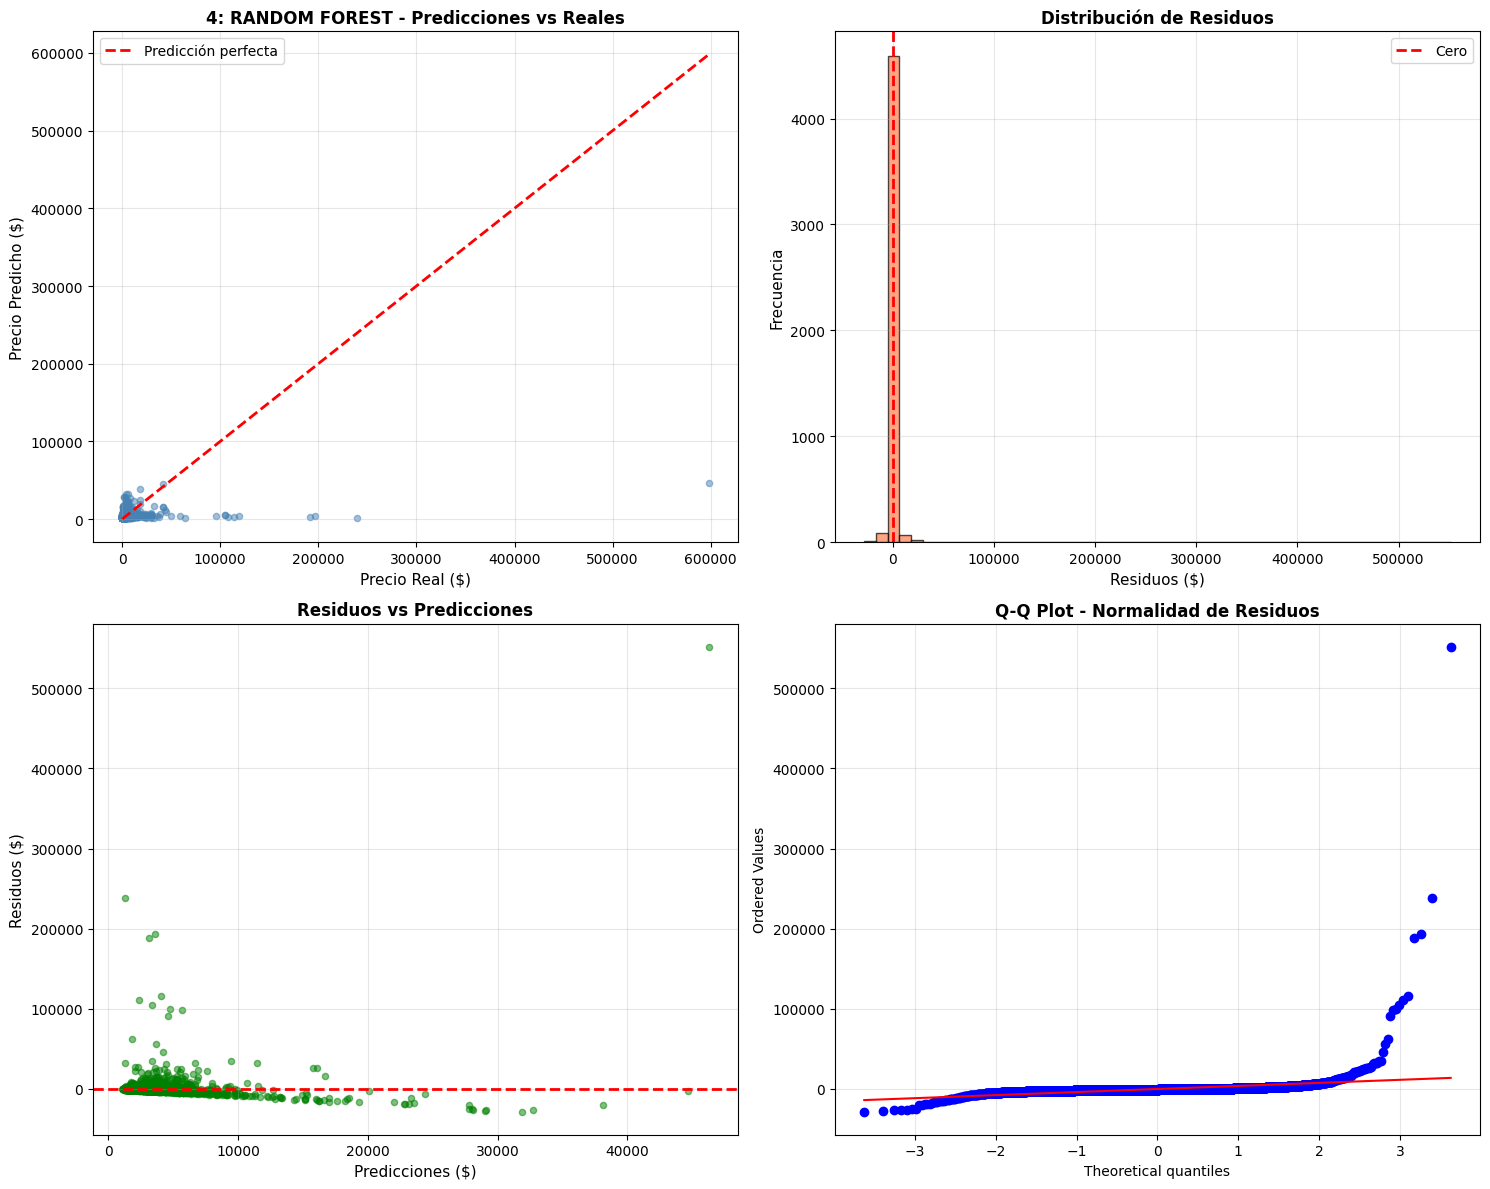


✓ Gráfico guardado: analisis_residuos.png

ESTADÍSTICAS DE RESIDUOS
Media:    $-227.96 (ideal: ~$0)
Mediana:  $-872.19
Desv.Std: $10,803.45
Mínimo:   $-28,332.40
Máximo:   $551,586.28


In [29]:
# Seleccionar el mejor modelo según RMSE Test
best_idx = comparison_df['RMSE_Test'].idxmin()
best_model_name = comparison_df.loc[best_idx, 'Modelo']
best_predictions = all_results[best_idx]['predictions']

print(f"\nMejor modelo: {best_model_name}")
print(f"RMSE Test: ${comparison_df.loc[best_idx, 'RMSE_Test']:,.2f}")

# Calcular residuos
residuals = y_test - best_predictions

# Visualización de residuos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicciones vs Valores Reales
axes[0, 0].scatter(y_test, best_predictions, alpha=0.5, s=20, color='steelblue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Predicción perfecta')
axes[0, 0].set_xlabel('Precio Real ($)', fontsize=11)
axes[0, 0].set_ylabel('Precio Predicho ($)', fontsize=11)
axes[0, 0].set_title(f'{best_model_name} - Predicciones vs Reales', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Distribución de Residuos
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Cero')
axes[0, 1].set_xlabel('Residuos ($)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribución de Residuos', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Residuos vs Predicciones
axes[1, 0].scatter(best_predictions, residuals, alpha=0.5, s=20, color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicciones ($)', fontsize=11)
axes[1, 0].set_ylabel('Residuos ($)', fontsize=11)
axes[1, 0].set_title('Residuos vs Predicciones', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Q-Q Plot de Residuos
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot - Normalidad de Residuos', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_residuos.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado: analisis_residuos.png")

# Estadísticas de residuos
print(f"\n{'='*70}")
print("ESTADÍSTICAS DE RESIDUOS")
print(f"{'='*70}")
print(f"Media:    ${residuals.mean():,.2f} (ideal: ~$0)")
print(f"Mediana:  ${residuals.median():,.2f}")
print(f"Desv.Std: ${residuals.std():,.2f}")
print(f"Mínimo:   ${residuals.min():,.2f}")
print(f"Máximo:   ${residuals.max():,.2f}")

## 8. Feature Importance (Modelos de Árbol)

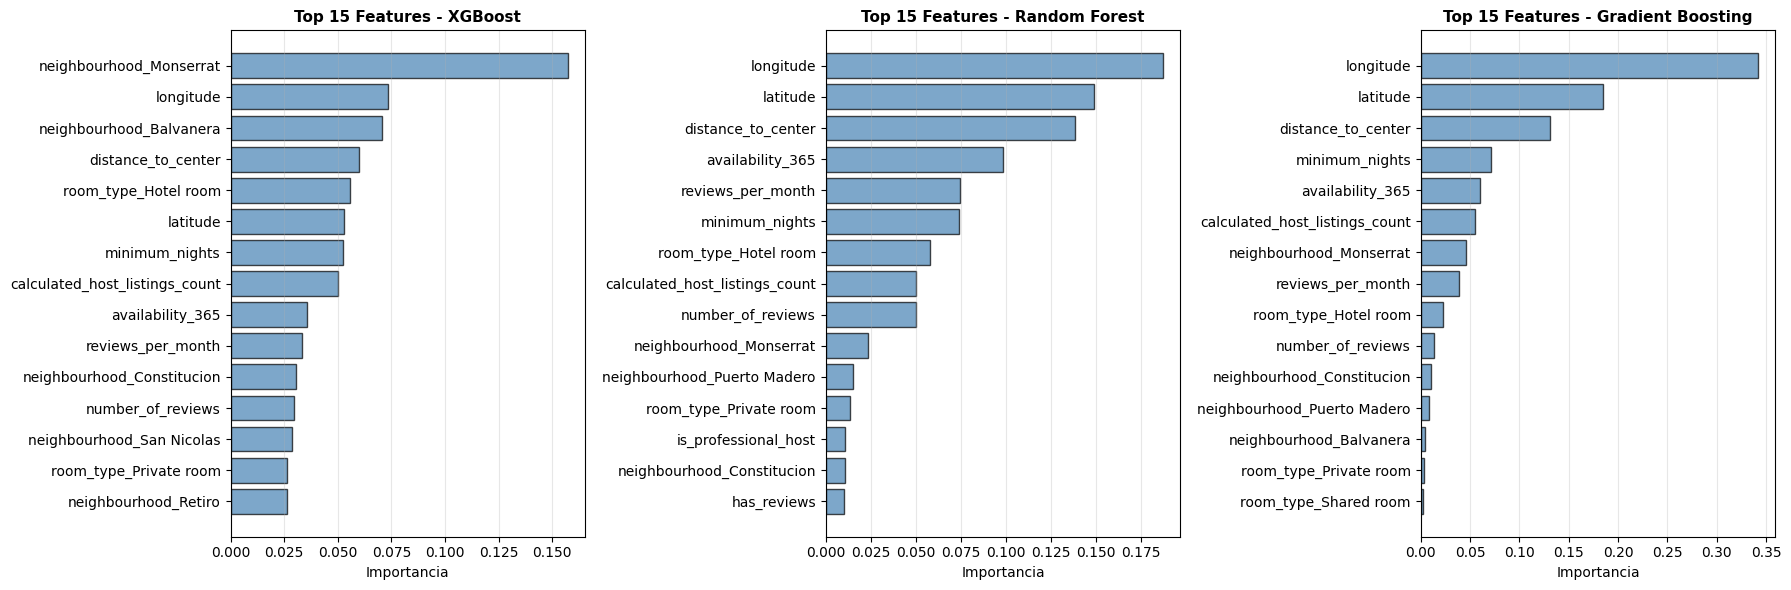


✓ Gráfico guardado: feature_importance_comparacion.png

TOP 10 FEATURES MÁS IMPORTANTES (XGBoost)


,Feature,Importance
28,neighbourhood_Monserrat,0.157454
1,longitude,0.073582
14,neighbourhood_Balvanera,0.070393
8,distance_to_center,0.059899
10,room_type_Hotel room,0.055771
0,latitude,0.052962
2,minimum_nights,0.052250
5,calculated_host_listings_count,0.050294
6,availability_365,0.035394
4,reviews_per_month,0.033489


In [30]:
# Feature importance de XGBoost, RF y GB
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models_importance = [
    ('XGBoost', xgb_model),
    ('Random Forest', rf_model),
    ('Gradient Boosting', gb_model)
]

for idx, (name, model) in enumerate(models_importance):
    # Top 15 features
    feature_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False).head(15)
    
    axes[idx].barh(feature_imp['Feature'], feature_imp['Importance'], 
                   color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel('Importancia', fontsize=10)
    axes[idx].set_title(f'Top 15 Features - {name}', fontsize=11, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado: feature_importance_comparacion.png")

# Mostrar top 10 de XGBoost
print(f"\n{'='*70}")
print("TOP 10 FEATURES MÁS IMPORTANTES (XGBoost)")
print(f"{'='*70}")
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)
display(xgb_importance)

## 9. Reentrenamiento con Dataset Completo

Para Kaggle, re-entrenamos usando TODO el dataset.

In [31]:
print("="*70)
print("REENTRENAMIENTO CON DATASET COMPLETO")
print("="*70)
print(f"\nEntrenando modelos con TODOS los {len(X):,} registros...")
print("\nEsto maximiza la información disponible para Kaggle.")

# XGBoost
print("\n1. XGBoost...")
xgb_final = xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=7,
    min_child_weight=3, subsample=0.8, colsample_bytree=0.8,
    gamma=0, reg_alpha=0.1, reg_lambda=1,
    random_state=42, n_jobs=-1, verbosity=0
)
xgb_final.fit(X, y)
print("   ✓ Entrenado")

# Gradient Boosting
print("\n2. Gradient Boosting...")
gb_final = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6,
    min_samples_split=10, min_samples_leaf=4, subsample=0.8,
    random_state=42
)
gb_final.fit(X, y)
print("   ✓ Entrenado")

# Random Forest
print("\n3. Random Forest...")
rf_final = RandomForestRegressor(
    n_estimators=200, max_depth=20, min_samples_split=8,
    min_samples_leaf=3, max_features='sqrt',
    random_state=42, n_jobs=-1
)
rf_final.fit(X, y)
print("   ✓ Entrenado")

print("\n" + "="*70)
print("✓ REENTRENAMIENTO COMPLETADO")
print("="*70)

REENTRENAMIENTO CON DATASET COMPLETO

Entrenando modelos con TODOS los 16,013 registros...

Esto maximiza la información disponible para Kaggle.

1. XGBoost...
   ✓ Entrenado

2. Gradient Boosting...
   ✓ Entrenado

3. Random Forest...
   ✓ Entrenado

✓ REENTRENAMIENTO COMPLETADO


## 10. Predicciones para Kaggle - Ensemble

Usamos ensemble ponderado:
- **50% XGBoost**
- **30% Gradient Boosting**
- **20% Random Forest**

In [32]:
print("="*70)
print("PREDICCIONES PARA KAGGLE - ENSEMBLE")
print("="*70)

# Predicciones individuales
print("\nGenerando predicciones...")
pred_xgb = xgb_final.predict(df_test_final)
pred_gb = gb_final.predict(df_test_final)
pred_rf = rf_final.predict(df_test_final)

print("✓ Predicciones XGBoost")
print("✓ Predicciones Gradient Boosting")
print("✓ Predicciones Random Forest")

# Ensemble
print("\nCreando ensemble ponderado (50% XGB + 30% GB + 20% RF)...")
predicciones_ensemble = 0.5 * pred_xgb + 0.3 * pred_gb + 0.2 * pred_rf

# Asegurar no negativos
predicciones_ensemble = np.maximum(predicciones_ensemble, 0)

print("\n" + "="*70)
print("ESTADÍSTICAS DE LAS PREDICCIONES FINALES")
print("="*70)
print(f"  Precio mínimo:   ${predicciones_ensemble.min():,.2f}")
print(f"  Precio máximo:   ${predicciones_ensemble.max():,.2f}")
print(f"  Precio promedio: ${predicciones_ensemble.mean():,.2f}")
print(f"  Precio mediana:  ${np.median(predicciones_ensemble):,.2f}")
print(f"  Desv. estándar:  ${np.std(predicciones_ensemble):,.2f}")

# Comparar con estadísticas de train
print(f"\n{'='*70}")
print("COMPARACIÓN CON DATASET DE ENTRENAMIENTO")
print(f"{'='*70}")
print(f"                    Train          Test (Predicciones)")
print(f"  Media:            ${y.mean():>10,.2f}    ${predicciones_ensemble.mean():>10,.2f}")
print(f"  Mediana:          ${y.median():>10,.2f}    ${np.median(predicciones_ensemble):>10,.2f}")
print(f"  Desv.Std:         ${y.std():>10,.2f}    ${np.std(predicciones_ensemble):>10,.2f}")

# Crear submission
submission = pd.DataFrame({
    'id': test_ids,
    'price': predicciones_ensemble
})

# Guardar
output_file = '../predictions/submission_kaggle_completo.csv'
submission.to_csv(output_file, index=False)

print(f"\n✓ Archivo guardado: {output_file}")
print(f"\nPrimeras 10 predicciones:")
display(submission.head(10))

print(f"\nÚltimas 10 predicciones:")
display(submission.tail(10))

PREDICCIONES PARA KAGGLE - ENSEMBLE

Generando predicciones...
✓ Predicciones XGBoost
✓ Predicciones Gradient Boosting
✓ Predicciones Random Forest

Creando ensemble ponderado (50% XGB + 30% GB + 20% RF)...

ESTADÍSTICAS DE LAS PREDICCIONES FINALES
  Precio mínimo:   $0.00
  Precio máximo:   $222,485.20
  Precio promedio: $3,284.84
  Precio mediana:  $2,807.85
  Desv. estándar:  $4,183.45

COMPARACIÓN CON DATASET DE ENTRENAMIENTO
                    Train          Test (Predicciones)
  Media:            $  3,286.10    $  3,284.84
  Mediana:          $  2,033.00    $  2,807.85
  Desv.Std:         $ 13,182.20    $  4,183.45

✓ Archivo guardado: ../predictions/submission_kaggle_completo.csv

Primeras 10 predicciones:


,id,price
0,15843708,2250.106478
1,9735218,1509.468020
2,35682605,2837.962276
3,9473906,2428.306554
4,34155238,1932.645449
5,8982316,2444.752500
6,39947050,1694.809190
7,9495427,3049.885423
8,1374387,719.142743
9,21497709,3293.219158



Últimas 10 predicciones:


,id,price
6854,38895570,26.403671
6855,1959063,3750.347551
6856,32761485,3479.200939
6857,66939,4552.127668
6858,38972601,3037.826257
6859,38432005,2373.713934
6860,21413242,1700.097337
6861,36595992,4345.877030
6862,20362823,3288.463007
6863,10849549,557.406342


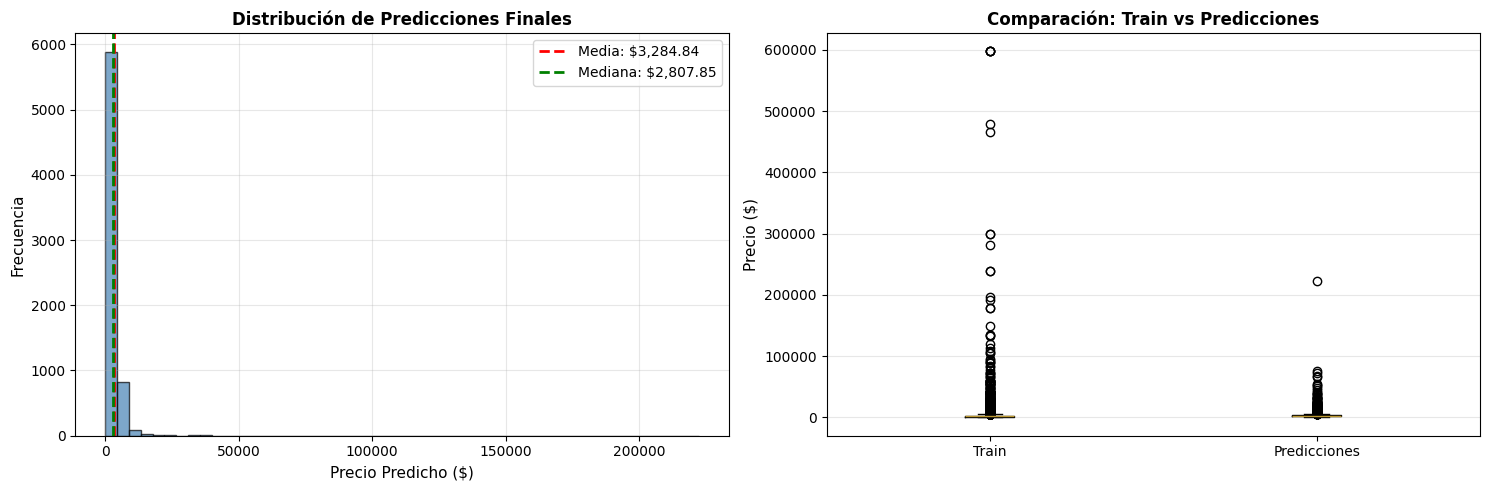

✓ Gráfico guardado: distribucion_predicciones_finales.png


In [33]:
# Visualización de distribución de predicciones
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma de predicciones
axes[0].hist(predicciones_ensemble, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(predicciones_ensemble.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: ${predicciones_ensemble.mean():,.2f}')
axes[0].axvline(np.median(predicciones_ensemble), color='green', linestyle='--', linewidth=2,
                label=f'Mediana: ${np.median(predicciones_ensemble):,.2f}')
axes[0].set_xlabel('Precio Predicho ($)', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].set_title('Distribución de Predicciones Finales', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
axes[1].boxplot([y, predicciones_ensemble], labels=['Train', 'Predicciones'])
axes[1].set_ylabel('Precio ($)', fontsize=11)
axes[1].set_title('Comparación: Train vs Predicciones', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('distribucion_predicciones_finales.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: distribucion_predicciones_finales.png")

## 11. Resumen Final

In [34]:
print("\n" + "="*70)
print("RESUMEN FINAL DEL PROYECTO")
print("="*70)

print("\n📊 DATOS:")
print(f"  - Registros train: {len(df_train):,} (SIN eliminar outliers)")
print(f"  - Registros test:  {len(df_test):,}")
print(f"  - Features finales: {X.shape[1]}")

print("\n🛠️  PREPROCESAMIENTO:")
print("  - Estrategia: Minimalista (conservar información)")
print("  - Outliers: NO eliminados")
print("  - Encoding: OneHotEncoder (robusto)")
print("  - Features creadas: 2 (distance_to_center, is_professional_host)")

print("\n🤖 MODELOS ENTRENADOS:")
print("  1. Linear Regression")
print("  2. Ridge Regression")
print("  3. Decision Tree")
print("  4. Random Forest")
print("  5. Gradient Boosting")
print("  6. XGBoost ⭐")
print("  3. Lasso Regression
")
print("  4. Decision Tree
")
print("  5. Random Forest
")
print("  6. Gradient Boosting
")
print("  7. XGBoost ⭐
")
print("  8. Neural Network")

print("\n🏆 MEJOR MODELO (Validación):")
best_model = comparison_df.iloc[0]
print(f"  - Modelo: {best_model['Modelo']}")
print(f"  - RMSE Test: ${best_model['RMSE_Test']:,.2f}")
print(f"  - MAE Test:  ${best_model['MAE_Test']:,.2f}")
print(f"  - R² Test:   {best_model['R2_Test']:.6f}")

print("\n🎯 MODELO FINAL (Kaggle):")
print("  - Estrategia: Ensemble Ponderado")
print("  - Composición:")
print("    • 50% XGBoost")
print("    • 30% Gradient Boosting")
print("    • 20% Random Forest")
print("  - Entrenamiento: TODO el dataset (16,013 registros)")

print("\n📁 ARCHIVOS GENERADOS:")
archivos = [
    'submission_kaggle_completo.csv',
    'model_comparison_completo.csv',
    'eda_distribucion_price.png',
    'analisis_outliers_boxplot.png',
    'analisis_categoricas.png',
    'distribucion_numericas.png',
    'analisis_correlaciones.png',
    'relaciones_bivariadas.png',
    'comparacion_completa_modelos.png',
    'analisis_residuos.png',
    'feature_importance_comparacion.png',
    'distribucion_predicciones_finales.png'
]
for i, archivo in enumerate(archivos, 1):
    print(f"  {i:2d}. {archivo}")

print("\n" + "="*70)
print("✓ ANÁLISIS COMPLETO FINALIZADO")
print("✓ LISTO PARA SUBIR A KAGGLE")
print("="*70)
print(f"\nArchivo para Kaggle: ../predictions/submission_kaggle_completo.csv")
print(f"Score esperado: Similar a ~8785 (posición 6/12)")


RESUMEN FINAL DEL PROYECTO

📊 DATOS:
  - Registros train: 16,013 (SIN eliminar outliers)
  - Registros test:  6,864
  - Features finales: 60

🛠️  PREPROCESAMIENTO:
  - Estrategia: Minimalista (conservar información)
  - Outliers: NO eliminados
  - Encoding: OneHotEncoder (robusto)
  - Features creadas: 2 (distance_to_center, is_professional_host)

🤖 MODELOS ENTRENADOS:
  1. Linear Regression
  2. Ridge Regression
  3. Decision Tree
  4. Random Forest
  5. Gradient Boosting
  6. XGBoost ⭐
  7. Neural Network

🏆 MEJOR MODELO (Validación):
  - Modelo: 4: RANDOM FOREST
  - RMSE Test: $10,804.73
  - MAE Test:  $2,206.17
  - R² Test:   0.077352

🎯 MODELO FINAL (Kaggle):
  - Estrategia: Ensemble Ponderado
  - Composición:
    • 50% XGBoost
    • 30% Gradient Boosting
    • 20% Random Forest
  - Entrenamiento: TODO el dataset (16,013 registros)

📁 ARCHIVOS GENERADOS:
   1. submission_kaggle_completo.csv
   2. model_comparison_completo.csv
   3. eda_distribucion_price.png
   4. analisis_outlie